In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


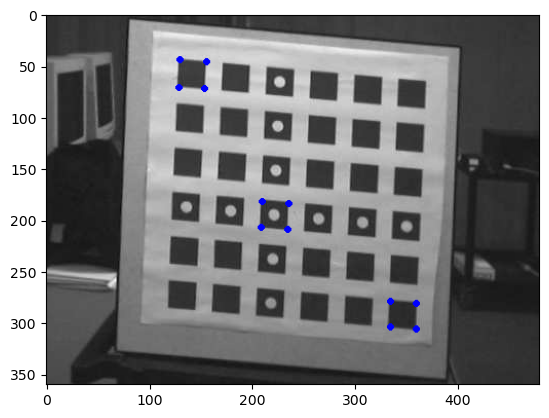

In [4]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [5]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))
back_3Dcoord = np.zeros((12, 3))
X = [0, 50, 50, 0, 160, 210, 210, 160, 400, 450, 450, 400]
Y = [0, 0, 50, 50, 240, 240, 290, 290, 400, 400, 450, 450]
for i in range(front_2Dcoord.shape[0]):
    front_3Dcoord[i, 0] = X[i]
    front_3Dcoord[i, 1] = Y[i]
    front_3Dcoord[i, 2] = 0
    back_3Dcoord[i, 0] = X[i]
    back_3Dcoord[i, 1] = Y[i]
    back_3Dcoord[i, 2] = 150

all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)

(24, 2) (24, 3)


In [6]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------

P = np.zeros((48, 12))
m = np.zeros((12, 1))

for i in range(all_2Dcoord.shape[0]):
    P[i*2, 0:3] = all_3Dcoord[i, 0:3]
    P[i*2, 3] = 1
    P[i*2, 4:8] = 0
    P[i*2, 8:11] = -all_2Dcoord[i, 0] * all_3Dcoord[i, 0:3]
    P[i*2, 11] = -all_2Dcoord[i, 0]
    P[i*2+1, 0:4] = 0
    P[i*2+1, 4:7] = all_3Dcoord[i, 0:3]
    P[i*2+1, 7] = 1
    P[i*2+1, 8:11] = -all_2Dcoord[i, 1] * all_3Dcoord[i, 0:3]
    P[i*2+1, 11] = -all_2Dcoord[i, 1]

# SVD
U, S, Vt = np.linalg.svd(P)
m = Vt[-1, :].reshape(12, 1)
m = m.reshape(3, 4)
print(m)

[[ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01]
 [ 3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01]
 [-6.97426063e-08  8.23266292e-08 -1.33752674e-08  7.29214554e-03]]


In [7]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

K = np.zeros((3, 3))
R = np.zeros((3, 3))
T = np.zeros((3, 1))

Ahat = m[:, :-1]
m = m / np.linalg.norm(Ahat[2])
A = m[:, :-1]
b = m[:, -1]
cx = np.dot(A[0], A[2])
cy = np.dot(A[1], A[2])
theta = np.arccos(np.dot(np.cross(A[1], A[2]), np.cross(A[2], A[0])) / (np.linalg.norm(np.cross(A[1], A[2])) * np.linalg.norm(np.cross(A[2], A[0]))))
alpha = np.linalg.norm(np.cross(A[0], A[2])) * np.sin(theta)
beta = np.linalg.norm(np.cross(A[1], A[2])) * np.sin(theta)
K = np.array([[alpha, -alpha / np.tan(theta), cx], [0, beta / np.sin(theta), cy], [0, 0, 1]])
r1 = np.cross(A[1], A[2]) / np.linalg.norm(np.cross(A[1], A[2]))
r3 = A[2]
r2 = np.cross(r3, r1)
R = np.array([r1, r2, r3])
T = np.dot(np.linalg.inv(K), b)
print(T)

[383001.84149469 -67357.81805465  67071.11345021]


In [8]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.